In [1]:
import pandas as pd
import inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from gensim.models import FastText
from sklearn.manifold import TSNE
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

pd.set_option('display.max_colwidth', None)

# Read CSV

In [2]:
df_bisnis = pd.read_csv("result/label/df_bisnis_labeled.csv") 
df_cnn = pd.read_csv("result/label/df_cnn_labeled.csv") 
df_liputan6 = pd.read_csv("result/label/df_liputan6_labeled.csv") 
df_tempo = pd.read_csv("result/label/df_tempo_labeled.csv")

In [3]:
df_bisnis["source"] = "bisnis"
df_cnn["source"] = "cnn"
df_liputan6["source"] = "liputan6"
df_tempo["source"] = "tempo"

In [4]:
def normal_eda(dataframe):
    callers_locals = inspect.currentframe().f_back.f_locals
    var_names = [name for name, val in callers_locals.items() if val is dataframe]
    var_name = var_names[0] if var_names else "dataframe"
    print(f"EDA for {var_name}")
    print()
    dataframe.info()
    print(f"\nDuplicate Count: {dataframe.duplicated().sum()}")
    print(f"Null Values Count: {dataframe.isna().sum().sum()}")
    print("\nLabel Value Counts:")
    print(dataframe['label'].value_counts())


In [5]:
for df in [df_bisnis,df_liputan6,df_cnn,df_tempo]:
    normal_eda(df)
    print("\n"+ "="*55+"\n")

EDA for df_bisnis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5513 entries, 0 to 5512
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           5513 non-null   object
 1   domain        5513 non-null   object
 2   title         5513 non-null   object
 3   date          5513 non-null   object
 4   clean_text    5513 non-null   object
 5   label         5513 non-null   object
 6   label_reason  5513 non-null   object
 7   source        5513 non-null   object
dtypes: object(8)
memory usage: 344.7+ KB

Duplicate Count: 0
Null Values Count: 0

Label Value Counts:
label
Neutral      2712
Inflation    1933
Deflation     868
Name: count, dtype: int64


EDA for df_liputan6

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2809 entries, 0 to 2808
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           2809 non-null   object
 1   domai

## Concat

In [6]:
df = pd.concat([df_bisnis,df_liputan6,df_cnn,df_tempo], ignore_index=True)

In [7]:
normal_eda(df)

EDA for df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9226 entries, 0 to 9225
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           9226 non-null   object
 1   domain        9226 non-null   object
 2   title         9226 non-null   object
 3   date          9226 non-null   object
 4   clean_text    9226 non-null   object
 5   label         9226 non-null   object
 6   label_reason  9226 non-null   object
 7   source        9226 non-null   object
dtypes: object(8)
memory usage: 576.8+ KB

Duplicate Count: 0
Null Values Count: 0

Label Value Counts:
label
Neutral      4563
Inflation    3292
Deflation    1371
Name: count, dtype: int64


As you can see that the labelled values are dominantly with Neutral (4563), then Inflation (3292), and last Deflation (1371)

In [8]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# EDA Final Data

In [9]:
plt.style.use("fivethirtyeight")
color_map = {
    "Inflation": "#F28B82",  
    "Deflation": "#81D4FA",  
    "Neutral":  "#F2C879"    
}

## Label Distribution

Text(0.5, 1.0, 'Sentiment Label Distribution')

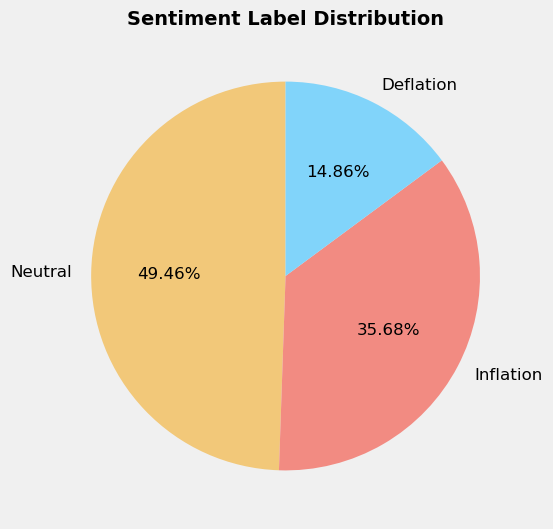

In [10]:
label_counts = df["label"].value_counts()

fig,ax = plt.subplots(figsize=(6,6))
ax.pie(
    label_counts,
    labels=label_counts.index,
    autopct="%.2f%%",
    startangle=90,
    colors=[color_map[label] for label in label_counts.index],
    textprops={'fontsize':12, "color":"Black"}
)
ax.set_title("Sentiment Label Distribution", fontsize = 14, fontweight = "bold")

## Label Count Over Time

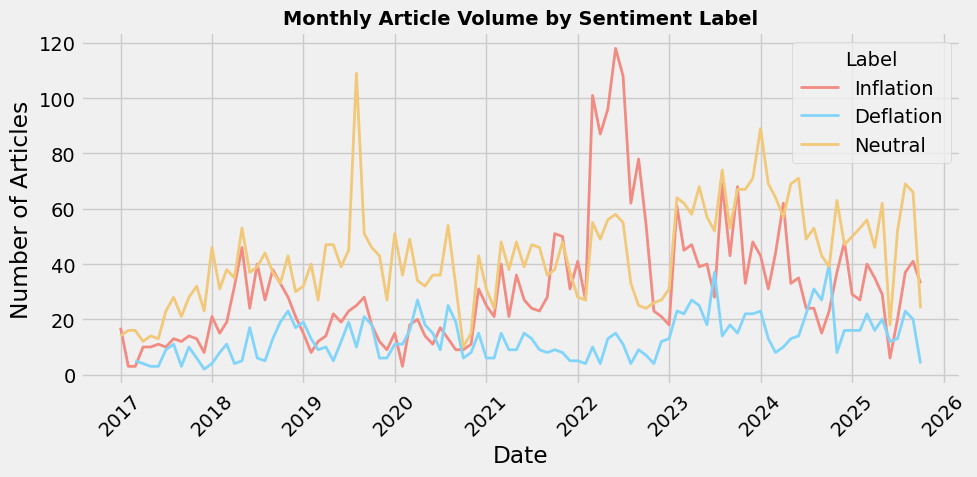

In [11]:
df["year_month"] = df["date"].dt.to_period("M")
monthly_counts = df.groupby(["year_month","label"]).size().reset_index(name="count")

# pivot plotting
pivot_monthly = monthly_counts.pivot(index="year_month",columns="label",values="count")
pivot_monthly.index = pivot_monthly.index.to_timestamp()  

fig, ax = plt.subplots(figsize=(10, 5))
for label in color_map:
    if label in pivot_monthly.columns:
        ax.plot(
            pivot_monthly.index,
            pivot_monthly[label],
            label=label,
            color=color_map[label],
            linewidth=2
        )

ax.set_title("Monthly Article Volume by Sentiment Label", fontsize=14, fontweight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Articles")
ax.legend(title="Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The most significantr trend is the explosive surge in inflation labeled articles (red line) starting in late 2021 and peaking in early 2022 at almost 120 articles. Before this pero, inflation coverage was relatively low and stable. This sharp peak indicates a massive shift in media foucs, where inflation temporarily overtook "Neutral" reporting to become the primary economic narative caused by the post Covid-19 effect.


Neutral aritcles (yellow line) represent the dominant volume for the majority of the timeframe, consistently hovering between 40 and 60 articles per month. This suggests that most economic reprting avoids definitive directional labeling. However, a distinct, isolated spike occurs in early 2020. This anomaly aligns with the onset of global economic uncertainty (likely the start of the COVID-19 pandemic), where article volume increased significantly without a clear consensus on price direction, resulting in a surge of non-committal, neutral coverage.


The Deflation label (blue line) consistently acts as the noise floor of the dataset, rarely exceeding 20 articles per month. Even during periods of high volatility (2020 and 2022), deflationary coverage sees only minor correlations with the broader trends. This demonstrates that deflation is rarely a primary concern in public or media discourse compared to inflation. The gap between the blue line and the others confirms that fear or discussion of rising prices drives significantly more content volume than the risk of falling prices.

## Monthly Trend By Year

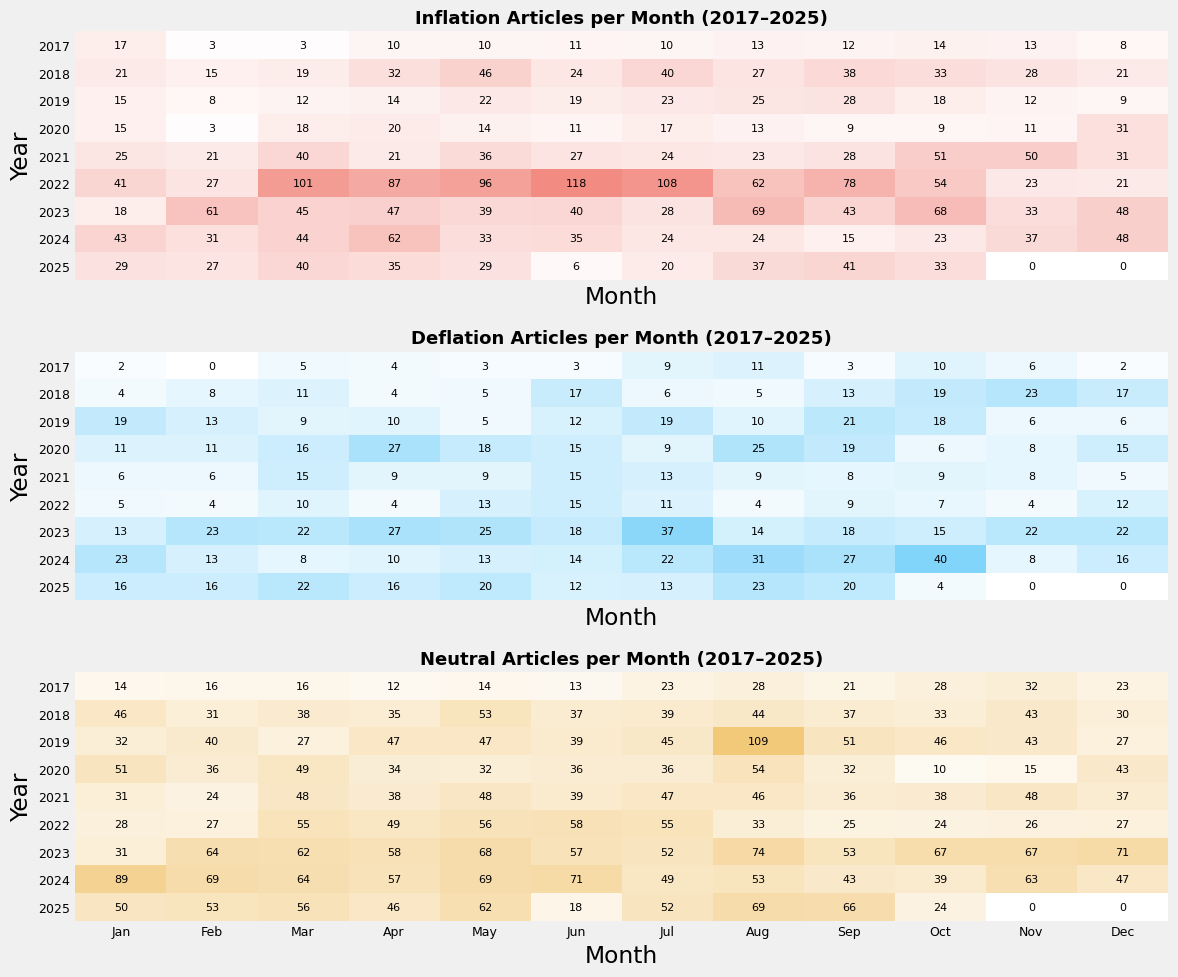

In [12]:
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df = df[df["year"].between(2017, 2025)]

monthly_counts = (
    df.groupby(["year", "month", "label"])
      .size()
      .reset_index(name="count")
)

labels = ["Inflation", "Deflation", "Neutral"]
years = sorted(df["year"].unique())
months = range(1, 13)
month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
fig, axes = plt.subplots(len(labels), 1, figsize=(12, 10), sharex=True)

for i, label in enumerate(labels):
    subset = monthly_counts[monthly_counts["label"] == label]
    pivot = subset.pivot(index="year", columns="month", values="count").fillna(0)
    data = pivot.reindex(index=years, columns=months, fill_value=0).values

    ax = axes[i]
    ax.set_facecolor("white") 
    norm_data = data / data.max() if data.max() > 0 else data
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            ax.add_patch(plt.Rectangle(
                (x-0.5, y-0.5), 1, 1,
                color=color_map[label],
                alpha=norm_data[y, x],
                lw=0,          
                ec=None
            ))
            ax.text(x, y, str(int(data[y, x])), ha="center", va="center", color="black", fontsize=8)

    ax.set_xlim(-0.5, len(months)-0.5)
    ax.set_ylim(len(years)-0.5, -0.5)
    ax.set_xticks(np.arange(len(months)))
    ax.set_xticklabels(month_labels, rotation=0, fontsize=9)
    ax.set_yticks(np.arange(len(years)))
    ax.set_yticklabels(years, fontsize=9)
    ax.tick_params(length=0)

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(False)

    ax.set_title(f"{label} Articles per Month (2017–2025)", fontsize=13, fontweight="bold")
    ax.set_ylabel("Year")
    ax.set_xlabel("Month")

plt.tight_layout()
plt.show()


The Inflation heatmap (top) visualizes the 2022 surge. Unlike a gradual build-up, there is a distinct wall of intensity starting in March 2022 (101 articles) and sustaining high volume through July 2022 (108 articles). This five-month block is the only period in the entire dataset where volume consistently exceeds 90 articles per month. This indicates that the "inflation crisis" narrative wasn't just a brief shock; it was a sustained, dominant media event that crowded out other economic coverage for nearly half a year.


The Neutral heatmap (bottom) reveals a singular, massive outlier in August 2019, with 109 articles. This value is nearly double the counts of the surrounding months (July: 45, September: 51). Such a sharp, isolated spike in non-directional reporting suggests a specific event that generated high noise but low consensus.




## Source Contribution

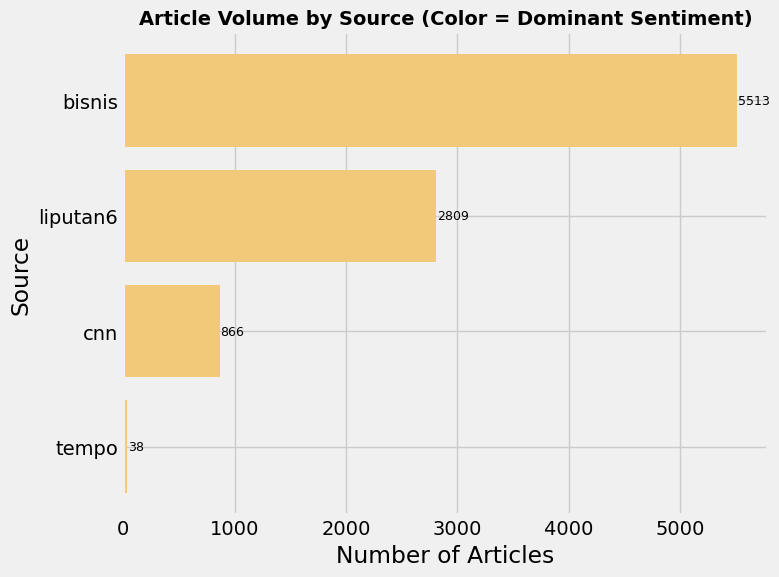

In [13]:
source_counts = df.groupby("source").size().reset_index(name="total_count")

dominant_label = (
    df.groupby(["source", "label"]).size()
    .reset_index(name="count")
    .sort_values(["source", "count"], ascending=[True, False])
    .drop_duplicates(subset=["source"])
)
source_counts = source_counts.merge(dominant_label[["source", "label"]], on="source", how="left")

source_counts = source_counts.sort_values("total_count", ascending=True)

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.barh(
    source_counts["source"],
    source_counts["total_count"],
    color=[color_map[lbl] for lbl in source_counts["label"]]
)

ax.set_xlabel("Number of Articles")
ax.set_ylabel("Source")
ax.set_title("Article Volume by Source (Color = Dominant Sentiment)", fontsize=14, fontweight="bold")

# Optional: label each bar
for bar in bars:
    width = bar.get_width()
    ax.text(width + 5, bar.get_y() + bar.get_height()/2,
            f"{int(width)}", va='center', fontsize=9)
plt.tight_layout()
plt.show()

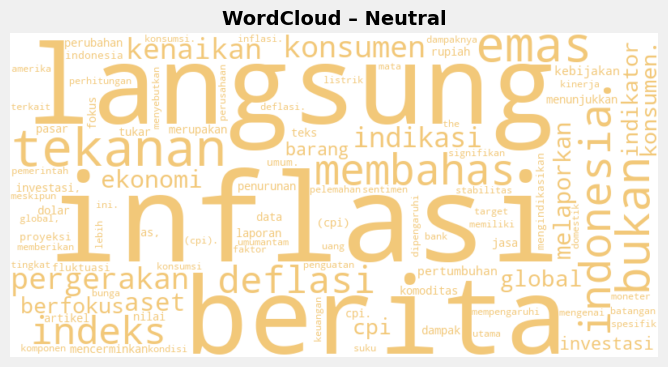

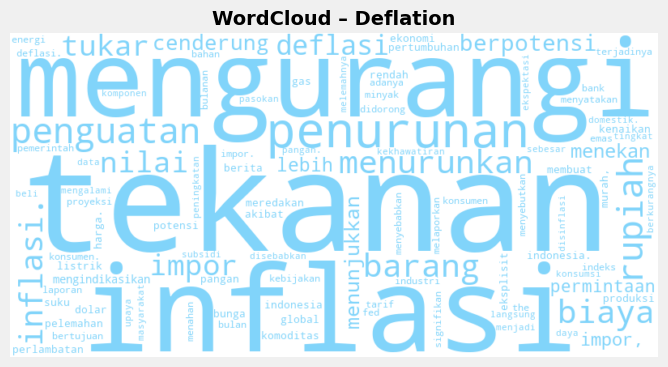

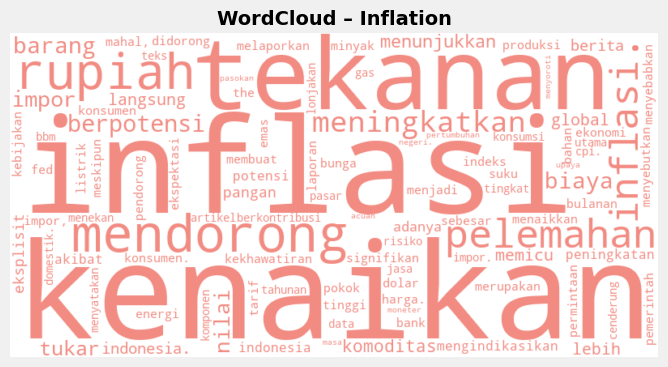

In [15]:
stopwords = set(StopWordRemoverFactory().get_stop_words())
custom_words = {"harga"}
stopwords.update(custom_words)


def top_terms_by_label(df, label_col="label", text_col="label_reason", top_n=100):
    results = {}
    for label in df[label_col].unique():
        subset = df[df[label_col] == label]
        all_words = " ".join(subset[text_col].astype(str)).lower()
        tokens = [
            w for w in all_words.split()
            if len(w) > 2 and w not in stopwords
        ]
        freq = Counter(tokens)
        results[label] = dict(freq.most_common(top_n))
    return results

top_terms = top_terms_by_label(df)

for label in top_terms:
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        color_func=lambda *args, **kwargs: color_map[label]
    ).generate_from_frequencies(top_terms[label])

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud – {label}", fontsize=14, fontweight="bold")
    plt.show()

Inflation is aggressive: The dominant verbs are "Mendorong" (Pushing/Driving) and "Meningkatkan" (Increasing). This implies inflation is viewed as an active, hostile force acting upon the economy, often driven by "Energi" (Energy) and "Biaya" (Cost).


Deflation is corrective or passive: The dominant verbs are "Mengurangi" (Reducing) and "Menurunkan" (Lowering). Unlike the aggressive "push" of inflation, deflation is framed as a dampening effect. Interestingly, the word "Penguatan" (Strengthening) appears here, likely referring to the Rupiah strengthening, which naturally lowers the cost of imported goods, leading to deflation.

## Text Length Vs Label

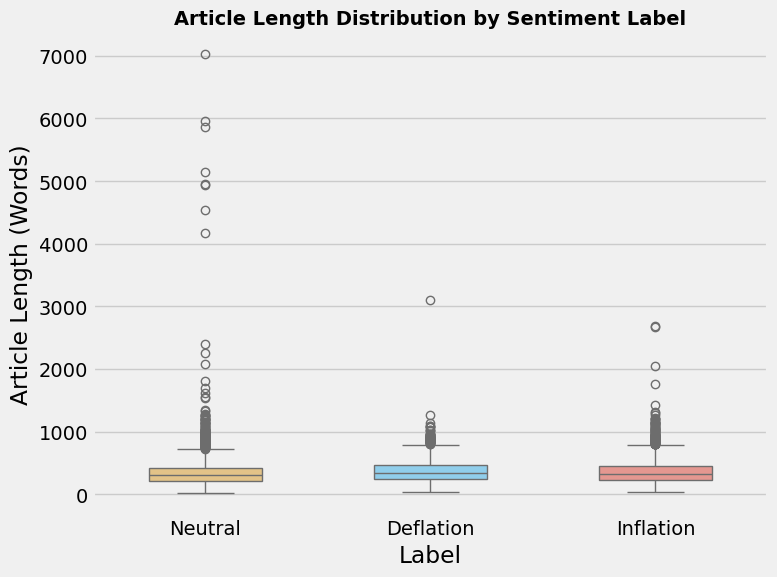

In [16]:
df["text_len"] = df["clean_text"].apply(lambda x: len(str(x).split()))

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x="label", y="text_len", data=df,hue = 'label',
            palette=color_map, width=0.5, ax=ax)
ax.set_title("Article Length Distribution by Sentiment Label", fontsize=14, fontweight="bold")
ax.set_xlabel("Label")
ax.set_ylabel("Article Length (Words)")
plt.tight_layout()
plt.show()


In [17]:
summary_stats = df.groupby('label')['text_len'].describe()
print(summary_stats)

            count        mean         std   min    25%    50%    75%     max
label                                                                       
Deflation  1371.0  367.916849  203.766813  38.0  243.5  339.0  464.0  3095.0
Inflation  3292.0  365.646719  212.844544  33.0  235.0  328.5  459.0  2688.0
Neutral    4563.0  347.047337  298.201916  26.0  218.0  303.0  422.5  7024.0


In [18]:
summary_stats_all = df['text_len'].describe()
print(summary_stats_all)

count    9226.000000
mean      356.785172
std       257.675514
min        26.000000
25%       227.000000
50%       316.000000
75%       445.000000
max      7024.000000
Name: text_len, dtype: float64


The data shows a high degree of standardization in the core article length across all three sentiments. The mean word counts are tightly grouped (Deflation: 367.9, Inflation: 365.6, Neutral: 347.0), and the Interquartile Ranges (IQR, the box plot body) are nearly identical in position and size. This indicates that the vast majority of articles adhere to a common length standard, suggesting `the basic unit of economic news delivery is consistent` regardless of whether the content is about rising prices, falling prices, or general stability.


`While Neutral articles have the lowest median length (303 words), they exhibit the highest variability`. This is confirmed by the largest standard deviation (298.2 words) and the presence of the most extreme outliers, including the maximum observed length of 7,024 words. This suggests that Neutral articles serve two purposes: quick factual reports (low median) and rare, highly detailed analytical pieces, white papers, or structural government announcements (high maximum outliers), which require extensive length and do not fit into the crisis-driven Inflation or Deflation categories.


`Despite having the lowest article volume (1,371 articles), the Deflation category features the highest median (339 words) and the highest mean word count (367.9 words).` This subtly suggests that when the media shifts focus to deflation, the reporting tends to be slightly more detailed and analytical than the standard Inflation piece. Deflation is a less frequent narrative, and its coverage is statistically more likely to be substantive and lengthy than the higher-volume, rapid-response reporting characteristic of an inflation crisis.


`Rarity drives depth.` Based on the summary statistics, there is a clear inverse relationship (negative correlation) between the volume of coverage and the depth of the articles. As a topic becomes more common, the articles about it tend to get shorter.

## STACKED PROPORTION OF LABEL PER SOURCE

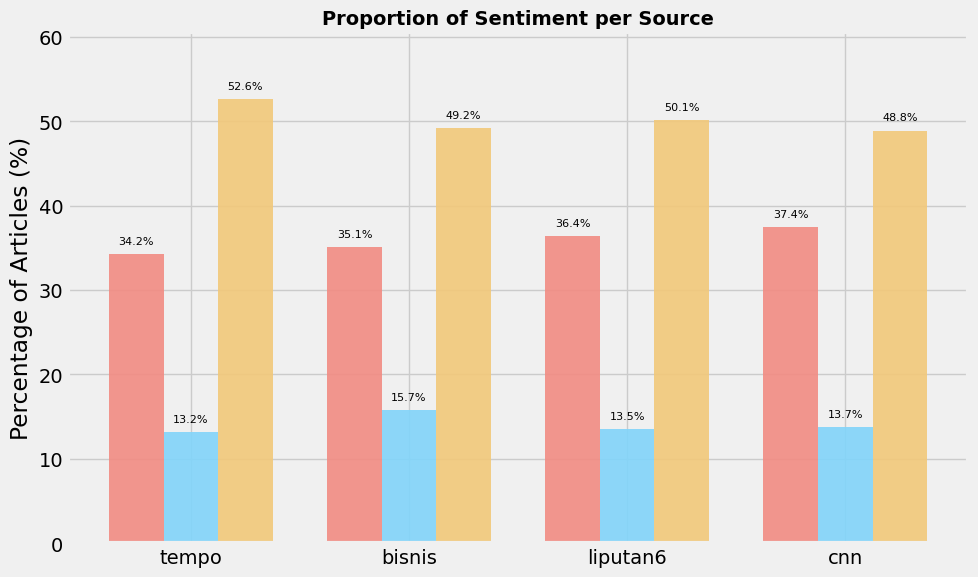

In [19]:
src_label = df.groupby(["source", "label"]).size().reset_index(name="count")
src_totals = src_label.groupby("source")["count"].sum().reset_index(name="total")
src_label = src_label.merge(src_totals, on="source")
src_label["percent"] = src_label["count"] / src_label["total"] * 100

pivot_prop = src_label.pivot(index="source", columns="label", values="percent").fillna(0)
pivot_prop = pivot_prop.sort_values("Inflation", ascending=True)

labels = list(color_map.keys())
x = np.arange(len(pivot_prop))  
bar_width = 0.25                

fig, ax = plt.subplots(figsize=(10, 6))

for i, label in enumerate(labels):
    if label in pivot_prop.columns:
        y = pivot_prop[label]
        ax.bar(
            x + i * bar_width, y,
            width=bar_width, color=color_map[label],
            label=label, alpha=0.9
        )
        for xi, yi in zip(x + i * bar_width, y):
            ax.text(xi, yi + 1, f"{yi:.1f}%", ha='center', va='bottom', fontsize=8)

ax.set_xticks(x + bar_width)
ax.set_xticklabels(pivot_prop.index, rotation=0)
ax.set_ylabel("Percentage of Articles (%)")
ax.set_title("Proportion of Sentiment per Source", fontsize=14, fontweight="bold")
ax.margins(y=0.15)
plt.tight_layout()
plt.show()


Distribution of each label by each source are uniform.

## Total Article Volume Overtime

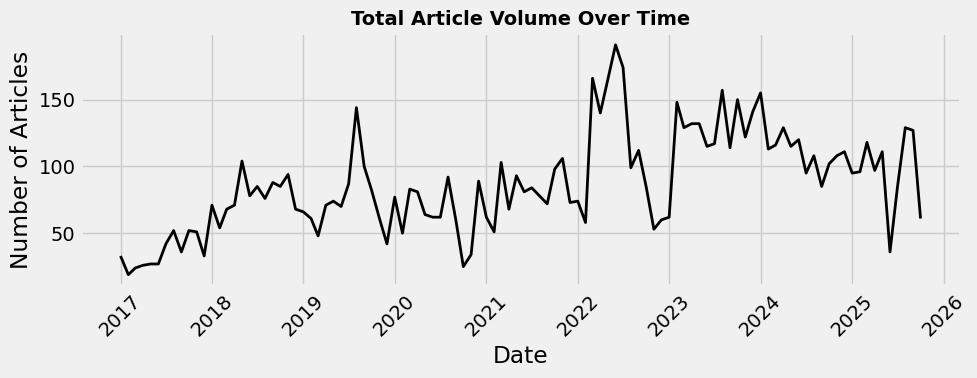

In [20]:
monthly_total = df.groupby(df["date"].dt.to_period("M")).size().reset_index(name="count")
monthly_total["date"] = monthly_total["date"].dt.to_timestamp()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(monthly_total["date"], monthly_total["count"], color="black", linewidth=2)
ax.set_title("Total Article Volume Over Time", fontsize=14, fontweight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Preprocessing

## Drop duplicates and fix whitespace

In [24]:
df = df.drop_duplicates(subset=["clean_text"]).reset_index(drop=True)
df["clean_text"] = df["clean_text"].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
df["title"] = df["title"].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()

## Normalize Label

In [25]:
df["label"] = df["label"].astype(str).str.strip().str.title()
df = df[df["label"].isin(["Inflation","Deflation","Neutral"])].reset_index(drop=True)

## Remove very short text

In [30]:
df = df[df["text_len"] >= 50].reset_index(drop=True)

## Cap at 3000

In [31]:
max_chars = 3000
df["clean_text"] = df["clean_text"].str.slice(0, max_chars)
df["text_len"] = df["clean_text"].str.len()

## Recompute Metadata

In [32]:
df["tokens"] = df["clean_text"].str.split().apply(len)
df["domain"] = df["domain"].astype(str).str.strip()
df["source"] = df["source"].astype(str).str.strip()
df["title"] = df["title"].astype(str).str.strip()

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["year_month"] = df["date"].dt.to_period("M").astype(str)


# Saved

In [33]:
df_final = df[
    [
        "url",
        "domain",
        "title",
        "date",
        "clean_text",
        "label",
        "label_reason",
        "source",
        "year_month",
        "year",
        "month",
        "tokens",
        "text_len"
    ]
].reset_index(drop=True)


In [37]:
print(df_final.head())

                                                                                                                       url  \
0         https://market.bisnis.com/read/20200629/235/1258875/harga-emas-semakin-dekati-us1.800-level-tertinggi-sejak-2011   
1           https://market.bisnis.com/read/20200826/93/1283222/mantap-rupiah-menguat-saat-mayoritas-mata-uang-asia-melemah   
2               https://market.bisnis.com/read/20200831/94/1285126/selain-emas-harga-minyak-juga-terbantu-lesunya-dolar-as   
3  https://market.bisnis.com/read/20210910/235/1440505/naik-tipis-harga-emas-24-karat-di-pegadaian-jumat-10-september-2021   
4                         https://market.bisnis.com/read/20200926/235/1296904/dolar-as-dinilai-lebih-aman-harga-emas-jatuh   

              domain  \
0  market.bisnis.com   
1  market.bisnis.com   
2  market.bisnis.com   
3  market.bisnis.com   
4  market.bisnis.com   

                                                                   title  \
0         Harga Emas S

In [39]:
df_final.describe()

,date,year,month,tokens,text_len
count,8992,8992.000000,8992.000000,8992.000000,8992.000000
mean,2022-01-26 02:29:05.551601664,2021.584408,6.392238,302.207963,2137.710965
min,2017-01-03 00:00:00,2017.000000,1.000000,50.000000,333.000000
25%,2020-02-03 18:00:00,2020.000000,4.000000,230.000000,1620.000000
50%,2022-06-02 00:00:00,2022.000000,6.000000,317.000000,2229.000000
75%,2024-01-03 00:00:00,2024.000000,9.000000,405.000000,3000.000000
max,2025-10-12 00:00:00,2025.000000,12.000000,559.000000,3000.000000
std,NaN,2.356549,3.280963,114.168166,808.742459


In [45]:
df_final['label'].value_counts()

label
Neutral      4443
Inflation    3221
Deflation    1328
Name: count, dtype: int64

In [38]:
df_final.to_csv("df_all_labeled_clean.csv", index=False)